<a href="https://colab.research.google.com/github/ACSE-mct22/acse_presessional/blob/main/testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pycm livelossplot
%pylab inline
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader, ConcatDataset
from torchvision.datasets import FashionMNIST
from torchvision.transforms import Compose, ToTensor
import torch.nn as nn
import numpy as np
from livelossplot import PlotLosses
import random
import torch.nn.functional as F

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 64 kB 1.9 MB/s 
     |████████████████████████████████| 595 kB 21.5 MB/s 
Populating the interactive namespace from numpy and matplotlib


In [2]:
def set_seed(seed):
    """
    Use this to set ALL the random seeds to a fixed value and take out any randomness from cuda kernels
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.benchmark = False  ##uses the inbuilt cudnn auto-tuner to find the fastest convolution algorithms. -
    torch.backends.cudnn.enabled   = False

    return True

device = 'cpu'
if torch.cuda.device_count() > 0 and torch.cuda.is_available():
    print("Cuda installed! Running on GPU!")
    device = 'cuda'
else:
    print("No GPU available!")

No GPU available!


/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [4]:
transformation = Compose([ToTensor()])
dataset_train = FashionMNIST('./', download=True, train=True, transform=transformation)
dataset_test = FashionMNIST('./', download=True, train=False, transform=transformation)

dataset = ConcatDataset((dataset_train, dataset_test)) # for generative models, we can use both the train and test datasets together
print(len(dataset))
#print(dir(data_train))
#print(data_train.train_data)

batch_size = 128
data = DataLoader(dataset, batch_size=batch_size, shuffle=True)

70000


In [13]:
torch.where(dataset.targets)

TypeError: ignored

In [4]:
print('Number of batches:', data.__len__())
print('Total images:', data.batch_size*data.__len__())

images, labels = next(iter(data))
channels = 1 if len(images.size()) == 3 else images.size()[1]
print(f'Image shape: {channels} channel(s) with {images[0].shape[0]}x{images[0].shape[1]} pixels, total pixels: {images[0].shape[0]*images[0].shape[1]}')
print(f'Maximum value is {images.max()} and minimum is {images.min()}')

Number of batches: 547
Total images: 70016
Image shape: 1 channel(s) with 1x28 pixels, total pixels: 28
Maximum value is 1.0 and minimum is 0.0


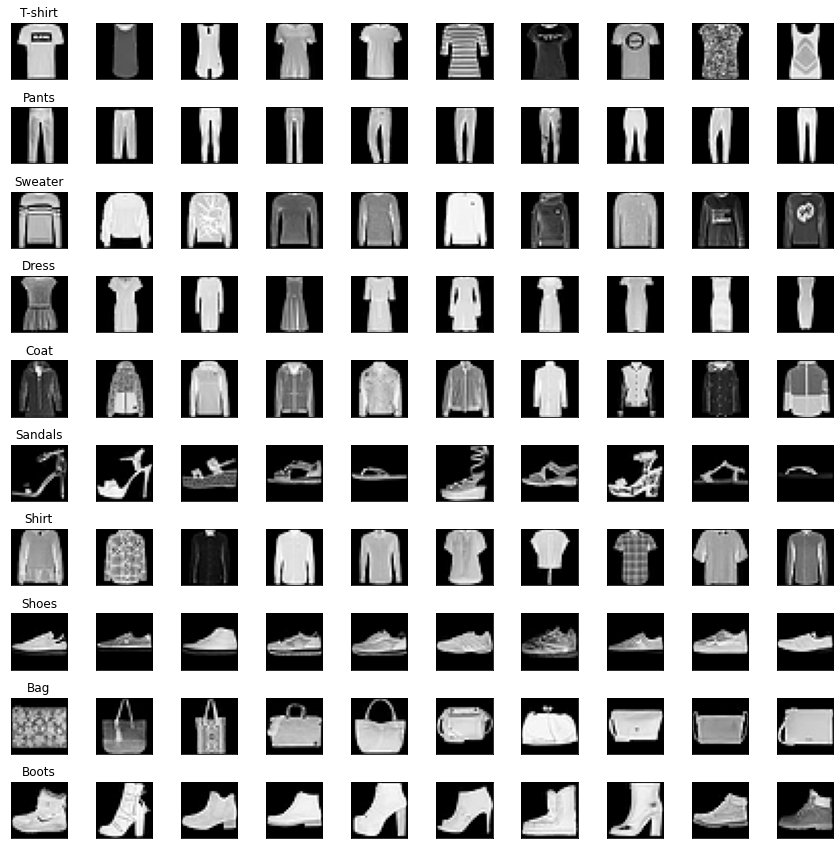

In [5]:
def plot_images(axs, name, idx, data):
  """Plot 10 images of a specific garment"""
  
  for ax, image in zip(axs, data[idx]):
    ax.imshow(image, cmap='gray')
    ax.set_xticks([])
    ax.set_yticks([])
  axs[0].title.set_text(name)

# Associate each label to the garment name
dic = {0: 'T-shirt',
       1: 'Pants',
       2: 'Sweater',
       3: 'Dress',
       4: 'Coat',
       5: 'Sandals',
       6: 'Shirt',
       7: 'Shoes',
       8: 'Bag',
       9: 'Boots'}

fig, axs = plt.subplots(10, 10, figsize=(15, 15))
plt.subplots_adjust(hspace=0.5)
for num, name in dic.items():
  idx = torch.where(dataset_train.targets == num)[:10]
  plot_images(axs[num], name, idx, dataset_train.data)

In [6]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [7]:
class Generator(nn.Module):
    def __init__(self, g_input_dim=100, g_output_dim=28*28):
        super().__init__()       
        self.fc1 = nn.Linear(g_input_dim, 256)
        self.fc2 = nn.Linear(self.fc1.out_features, self.fc1.out_features*2)
        self.fc3 = nn.Linear(self.fc2.out_features, self.fc2.out_features*2)
        self.fc4 = nn.Linear(self.fc3.out_features, g_output_dim)
    
    # forward method
    def forward(self, x): 
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.leaky_relu(self.fc3(x), 0.2)
        return torch.tanh(self.fc4(x))
    
class Discriminator(nn.Module):
    def __init__(self, d_input_dim=28*28):
        super().__init__()
        self.fc1 = nn.Linear(d_input_dim, 1024)
        self.fc2 = nn.Linear(self.fc1.out_features, self.fc1.out_features//2)
        self.fc3 = nn.Linear(self.fc2.out_features, self.fc2.out_features//2)
        self.fc4 = nn.Linear(self.fc3.out_features, 1)
    
    # forward method
    def forward(self, x):
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = F.dropout(x, 0.3)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.dropout(x, 0.3)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = F.dropout(x, 0.3)
        return torch.sigmoid(self.fc4(x))
    

# build model
G = Generator().to(device)
D = Discriminator().to(device)

In [8]:
# define loss
criterion = nn.BCELoss() 
z_dim = 100
bs = 100  ## batch_size


# optimiser
lr = 0.0001 
G_optimizer = torch.optim.Adam(G.parameters(), lr = lr)
D_optimizer = torch.optim.Adam(D.parameters(), lr = lr)

In [15]:
def D_train(x):
    #-------------- Function of the discriminator training -------------------#
    D.train()
    D_optimizer.zero_grad()

    # train discriminator on real data -- assign high score (use 1 here)
    x_real, y_real = x.view(-1, 28*28), torch.ones(x.size(0), 1)  # we are assigning the label 'real data' to the samples (don't care anymore about what number they are)
    x_real, y_real = x_real.to(device), y_real.to(device)

    D_output = D(x_real)
    D_real_loss = criterion(D_output, y_real)

    # train discriminator on fake data -- assign low score (use 0 here)
    # sample vector and produce generator output
    z = torch.randn(x.size(0), z_dim).to(device)
    x_fake, y_fake = G(z), torch.zeros(x.size(0), 1).to(device)

    D_output = D(x_fake)
    D_fake_loss = criterion(D_output, y_fake)

    # combine the losses
    D_loss = D_real_loss + D_fake_loss

    # model update 
    D_loss.backward()
    D_optimizer.step()
        
    return  D_loss.data.item()  ### deprecated version of loss.detach(), basically gets access to the tensor without the computational graph attached

In [13]:
def G_train(x):
    #-------------- Function of the generator training -------------------#
    G.train()
    G_optimizer.zero_grad()

    # sample vector and produce generator output
    z = torch.randn(x.size(0), z_dim).to(device)
    G_output = G(z)

    # obtain scores from D for the generated data
    D_output = D(G_output)

    # train generator to "fool" discriminator
    y = torch.ones(x.size(0), 1).to(device)
    G_loss = criterion(D_output, y)

    # model update 
    G_loss.backward()
    G_optimizer.step()
        
    return G_loss.data.item()  ### deprecated version of loss.detach(), basically gets access to the tensor without the computational graph attached

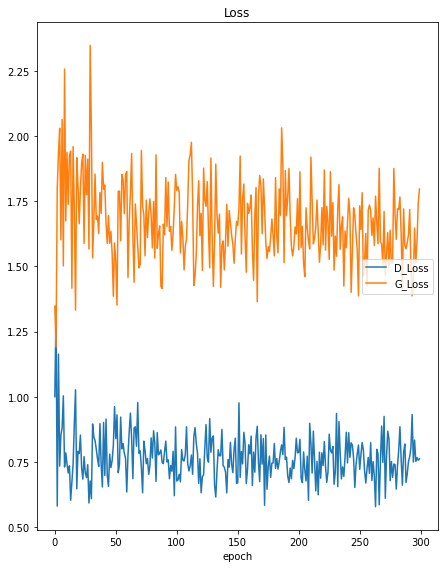

Loss
	D_Loss           	 (min:    0.578, max:    1.327, cur:    0.762)
	G_Loss           	 (min:    1.192, max:    2.348, cur:    1.797)


In [17]:
n_epoch = 300 # about 40 minutes
groups = {'Loss': ['D_Loss', 'G_Loss']}
liveloss = PlotLosses(groups=groups)

for epoch in range(1, n_epoch+1):  
  D_losses, G_losses = [], []
  logs = {}
  for batch_idx, (x, _) in enumerate(data):
    logs['D_Loss'] = D_train(x)
    logs['G_Loss'] = G_train(x)
  liveloss.update(logs)
  liveloss.draw()

  # save every 20th epochs
  if(np.mod(epoch, 20) == 0):
    torch.save(G.state_dict(), "./Generator_test{:03d}.pth".format(epoch))

In [28]:
!mv gdrive/MyDrive/*.pth gdrive/MyDrive/models/
#gdrive/MyDrive

In [ ]:
# from torchvision.utils import save_image
set_seed(0)

epoch = 20  ## get the model after 20 epochs and use it:
G.load_state_dict(torch.load("./Generator_test{t:03d}.pth".format(epoch)))


with torch.no_grad():
    test_z = torch.randn(bs, z_dim).to(device)
    generated = G(test_z)

    # save_image(generated.view(generated.size(0), 1, 28, 28), './sample_' + '.png')
fig, axarr = plt.subplots(10, 10, figsize=(12, 12))
for ax, img in zip(axarr.flatten(), generated.view(generated.size(0), 28, 28).cpu()):
  ax.imshow(img, cmap="gray")
plt.title('Epoch = {:03d}'.format(epoch))

# Junkyard

In [ ]:
# Working Convolutional GAN
class Generator(nn.Module):
    def __init__(self, g_input_dim=z_dim, g_output_dim=28*28, g_label_dim=10):
        # we initialise with an input layer that can included the encoded label
        super().__init__()
        self.lle = g_label_dim     
        self.fc1 = nn.Linear(g_input_dim+g_label_dim, 256)
        self.fc2 = nn.Linear(self.fc1.out_features, self.fc1.out_features*2)
        self.fc3 = nn.Linear(self.fc2.out_features, self.fc2.out_features*2) # 1024
        self.fc4 = nn.Linear(self.fc3.out_features, 784)

        #self.conv1 = nn.ConvTranspose2d(16, 8, kernel_size=(5,5))
        #self.conv2 = nn.ConvTranspose2d(8, 1, kernel_size=(22,22))
        #self.conv3 = nn.ConvTranspose2d(4, 1, kernel_size=(13,13))

    def input_encoder(self, z, labels):
        """Takes a list of labels, one-hot-encodes them and adds them to the images"""
        labels = encode_labels(labels, self.lle).to(device)
        z = torch.cat((z, labels), dim=1)
        return z

    def forward(self, x, labels): 
        x = self.input_encoder(x, labels)
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = torch.tanh(self.fc4(x))

        #x = x.view(-1, 16, 4, 4)
        #x = self.conv1(x)
        #x = self.conv2(x)
        #x = self.conv3(x)

        return x.view(-1, 28*28)
    
class Discriminator(nn.Module):
    def __init__(self, d_input_dim=28*28, d_label_dim=10):
        super().__init__()
        self.lle = d_label_dim
        self.conv1 = nn.Conv2d(1, 2, kernel_size=(3,3))
        self.conv2 = nn.Conv2d(2, 4, kernel_size=(3,3))
        self.conv3 = nn.Conv2d(4, 8, kernel_size=(3,3))

        self.fc1 = nn.Linear(3872+d_label_dim, 512)
        self.fc2 = nn.Linear(self.fc1.out_features, self.fc1.out_features//2)
        self.fc3 = nn.Linear(self.fc2.out_features, self.fc2.out_features//2)
        self.fc4 = nn.Linear(self.fc3.out_features, 1)

    def input_encoder(self, x, labels):
        """Takes a list of labels, one-hot-encodes them and adds them to the images"""
        labels = encode_labels(labels, self.lle) 
        x = torch.cat((x, labels), dim=1) 
        return x
    
    # forward method
    def forward(self, x, labels=torch.Tensor([1])):
        x = x.view(-1, 1, 28, 28)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)

        x = x.view(-1, 3872)
        x = self.input_encoder(x, labels.to(device))
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = F.dropout(x, 0.3)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.dropout(x, 0.3)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = F.dropout(x, 0.3)
        return torch.sigmoid(self.fc4(x))
    

# build models and their optimizers
G = Generator().to(device)
D = Discriminator().to(device)
G_optimizer = torch.optim.Adam(G.parameters(), lr=lr)
D_optimizer = torch.optim.Adam(D.parameters(), lr=lr)